<center><h1>Stack Overflow Search Engine</h1></center>

In [0]:
#installing packages (since i'm using google colab,i'm installing from notebook itself)

#%%capture
##Install the latest Tensorflow version.
#!pip3 install --upgrade tensorflow-gpu
##Install TF-Hub.
#!pip3 install tensorflow-hub
#!pip install bert-tensorflow
#!pip install bert_embedding
#!pip3 install --upgrade gensim
#!pip3 install --upgrade numpy
#!pip install normalise
#import nltk
#nltk.download('punkt')
#nltk.download('brown')
#nltk.download('names')
#nltk.download('stopwords')

In [0]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import tensorflow_hub as tf_hub
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle
import time
import datetime
import os
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.stats import entropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from IPython.display import HTML
from scipy import sparse

from functools import partial
import time
from datetime import datetime

from google.colab import auth
from google.cloud import bigquery
from google.colab import drive

<h1>Mounting the Drive </h1>

In [0]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<h1>Variables</h1>

In [0]:
currentDirectory = "/content/drive/My Drive/pcase_study_1/"
os.chdir(currentDirectory)
currentDirectory = ""
dataDirectory = currentDirectory + "data/"
modelsDirectory = currentDirectory + "models/"
column = 'complete_question'

<h1>Reading Word2Vec Model</h1>


In [0]:
#reading Pre-Trained W2V
model_w2v = gensim.models.word2vec.Word2Vec.load(modelsDirectory+'w2v.bin') #reading pre-trained

<h1>Loading Data</h1>

In [0]:
#X_train = pd.read_csv(dataDirectory + 'train_data.csv')
#X_test = pd.read_csv(dataDirectory + 'test_data.csv')
#
#data =  pd.read_csv(dataDirectory + 'data.csv')
#data = data[['id','title']]
#
#searchData = pd.concat([X_train,X_test])
#searchData = searchData[['id',column,'score','tags','sentiment_polarity','sentiment_subjectivity','neg','neu','pos','compound']]
#
#data = pd.merge(searchData, data, how ='inner', on ='id')
#
#data.to_csv(dataDirectory + 'search_data.csv',encoding='utf-8',index=False)

In [0]:
data =  pd.read_csv(dataDirectory + 'search_data.csv')
scaler = MinMaxScaler()
data[['score']] = scaler.fit_transform(data[['score']])
data.head(2)

,id,complete_question,score,tags,sentiment_polarity,sentiment_subjectivity,neg,neu,pos,compound,title
0,17343032,implement converters entities java generics wo...,0.000298,java|spring|jsf|generics,0.008679,0.359622,0.032,0.798,0.170,0.9928,Implement converters for entities with Java Ge...
1,17110104,method use instead hazelcastgetmapmap using pr...,0.000060,java|collections,0.225000,0.450000,0.000,0.943,0.057,0.2500,What method should we use instead of Hazelcast...


<p>Sentence Embedding is most important. It involves converting the text representation of the questions into a numerical vector space.</p>

<p>Five different types of embedding techniques studied in this notebook.</p>
<ul>
<li>Average Word2Vec</li>
<li>TF-IDF Weighted Word2Vec</li>
<li>Smooth Inverse Frequency and Word2Vec</li>
<li>Universal Sentence Encode</li>
<li>BERT Embedding</li>
</ul>

**<p>And we will be studying Document Similarity LDA (Latent Dirichlet Allocation) </p>**

#<h1>1. Sentence Embedding using Average Word2Vec<h1>

In [0]:
def AvgWord2VecEmbeddings(sentences,model):
    vlookup = model.wv.vocab
    vectors = model.wv
    output = np.zeros(shape=(len(sentences), model.vector_size), dtype = np.float32)

    for i,s in enumerate(sentences):
        idx = [vlookup[w].index for w in s.split() if w in vlookup]
        if len(idx) > 0:
            v  = np.sum(vectors.vectors[idx], axis=0)
            v *= 1/len(idx)
            output[i] = v           
    return output

In [0]:
start_time = time.time()
questions = data[column].values
avg_W2V_emb = AvgWord2VecEmbeddings(questions, model_w2v)
print("time taken to convert {0} questions to vector using AvgW2V Model is {1} seconds".format(len(questions),time.time() - start_time))
print("Shape of the Senetence embedding",avg_W2V_emb.shape)

time taken to convert 929480 questions to vector using AvgW2V Model is 92.81342315673828 seconds
Shape of the Senetence embedding (929480, 300)


#<h1>2. Sentence Embedding using TF-IDF and Word2Vec<h1>

In [0]:
def TF_IDF_Word2VecEmbeddings(sentences,model_w2v,model_tfidf):
    vlookup = model_w2v.wv.vocab
    vectors = model_w2v.wv
    vocab_idf = dict(zip(model_tfidf.get_feature_names(), model_tfidf.idf_))

    output = np.zeros(shape=(len(sentences), model_w2v.vector_size), dtype = np.float32)


    for i,s in enumerate(sentences):
        idx = [vlookup[w].index for w in s.split() if w in vlookup and w in vocab_idf ]
        idf = np.array([vocab_idf[w] for w in s.split() if w in vlookup and w in vocab_idf ])

        if len(idx) > 0:
            v  = np.sum(vectors.vectors[idx] * idf[:,None] , axis=0)
            v *= 1/len(idx)
            output[i] = v           
    return output

In [0]:
start_time = time.time()
#questions = data[column].values
model_tfidf = TfidfVectorizer(min_df=10)
model_tfidf.fit(questions)
print("time taken to build TF-IDF model is {0} seconds".format(time.time() - start_time))

start_time = time.time()
TF_IDF_W2V_emb = TF_IDF_Word2VecEmbeddings(questions,model_w2v,model_tfidf)

print("time taken to convert {0} questions to vector using TF-IDF+W2V Model is {1} seconds".format(len(questions),time.time() - start_time))
print("Shape of the Senetence embedding",TF_IDF_W2V_emb.shape)

time taken to build TF-IDF model is 121.35671138763428 seconds
time taken to convert 929480 questions to vector using TF-IDF+W2V Model is 224.0520215034485 seconds
Shape of the Senetence embedding (929480, 300)


#<h1>3. Sentence Embedding using Smooth Inverse Frequency and Word2Vec<h1>

<h2>Smooth Inverse Frequency</h2>
<p>Taking the average of the word embeddings in a sentence tends to give too much weight to words that are quite irrelevant, semantically speaking. Smooth Inverse Frequency tries to solve this problem in two ways:</p>

<ul>
<li>
Weighting: SIF takes the weighted average of the word embeddings in the sentence. Every word embedding is weighted by a/(a + p(w)), where a is a parameter that is typically set to 0.001 and p(w) is the estimated frequency of the word in a reference corpus.
</li>
<li>
Common component removal: SIF computes the principal component of the resulting embeddings for a set of sentences. It then subtracts from these sentence embeddings their projections on their first principal component. This should remove variation related to frequency and syntax that is less relevant semantically.
</li>
</ul>



In [0]:
#https://github.com/PrincetonML/SIF/blob/master/src/SIF_embedding.py
def compute_pc(X,npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_*0.5

def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

def SIFWord2VecEmbeddings(sentences,model, alpha=1e-3):
    vlookup = model.wv.vocab
    vectors = model.wv
    output = np.zeros(shape=(len(sentences), model.vector_size), dtype = np.float32)

    Z = 0
    for k in vlookup:
        Z += vlookup[k].count # Compute the normalization constant Z

    for i,s in enumerate(sentences):
        idx = [vlookup[w].index for w in s.split() if w in vlookup]
        sif = np.array([( alpha / (alpha + (vlookup[w].count / Z))) for w in s.split() if w in vlookup])

        if len(idx) > 0:
            v  = np.sum(vectors.vectors[idx] * sif[:,None] , axis=0)
            v *= 1/len(idx)
            output[i] = v
    
    output = remove_pc(output, 2)

    return output

In [0]:
start_time = time.time()
#questions = data[column].values
SIF_W2V_emb = SIFWord2VecEmbeddings(questions, model_w2v)
print("time taken to convert {0} questions to vector using SIF+W2V Model is {1} seconds".format(len(questions),time.time() - start_time))
print("Shape of the Senetence embedding",SIF_W2V_emb.shape)

time taken to convert 929480 questions to vector using SIF+W2V Model is 219.27632856369019 seconds
Shape of the Senetence embedding (929480, 300)


#<h1>4.Universal Sentence Encoder</h1>

<p>The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.</p>

<p>The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. We apply this model to the STS benchmark for semantic similarity, and the results can be seen in the example notebook made available. The universal-sentence-encoder model is trained with a deep averaging network encoder.</p>

In [0]:
module_USE_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_USE = tf_hub.load(module_USE_url)

In [0]:
def USE_Embeddings(sentences,model):
    output = np.zeros(shape=(len(sentences), 512), dtype = np.float32)
    for i,s in enumerate(sentences):
      v = np.array(model([s]))
      output[i] = v.reshape(-1) 
    return output

In [0]:
start_time = time.time()
questions = data[column].values
USE_emb = USE_Embeddings(questions, model_USE)
print("time taken to convert {0} questions to vector using Universal Sentence Encoder Model is {1} seconds".format(len(questions),
                                                                                                                   time.time() - start_time))
print("Shape of the Senetence embedding",USE_emb.shape)

time taken to convert 929480 questions to vector using Universal Sentence Encoder Model is 5723.34011721611 seconds
Shape of the Senetence embedding (929480, 512)


In [0]:
#np.save(modelsDirectory+'USE_emb', USE_emb)
USE_emb = np.load(modelsDirectory+'USE_emb.npy')

#<h1>5. Sentence Encoder using BERT</h1>

<h3>BERT: Bidirectional Encoder Representations from Transformers</h3>

<p>BERT model published by the google is currently the state of the art model for doing NLP related tasks. BERT which is an LSTM model works based on the concept of attention trying to predict the next token based on the series of the previous tokens it encountered.BERT based embedding may prove useful for this project to extract more meaningful information from the post text</p>


In [0]:
from bert_embedding import BertEmbedding
model_bert = BertEmbedding()

Vocab file is not found. Downloading.


In [0]:
def BERT_Embeddings(sentences,model):
    output = np.zeros(shape=(len(sentences), 768), dtype = np.float32)
    for i,s in enumerate(sentences):
      v = model([s])[0][1]
      length = len(v)
      v = np.sum(v,axis=0)
      v *= 1/length
      output[i] = v
    return output

In [0]:
start_time = time.time()
questions = data[column].values
BERT_emb = BERT_Embeddings(questions, model_bert)
print("time taken to convert {0} questions to vector using BERT Model is {1:0.2f} minutes".format(len(questions),(time.time() - start_time)/60))
print("Shape of the Senetence embedding",BERT_emb.shape)

In [0]:
#np.save(modelsDirectory+'BERT_emb', BERT_emb)
BERT_emb = np.load(modelsDirectory+'BERT_emb.npy')

#<h1>6. Similary Using Latent Dirichlet Allocation and Jensen-Shannon distance</h1>

<h3>LDA</h3>

<p>Latent Dirichlet Allocation, is an unsupervised generative model that assigns topic distributions to documents.</p>

</p>At a high level, the model assumes that each document will contain several topics, so that there is topic overlap within a document. The words in each document contribute to these topics. The topics may not be known a priori, and needn't even be specified, but the number of topics must be specified a priori. Finally, there can be words overlap between topics, so several topics may share the same words.</p>

<p>The model generates to latent (hidden) variables 
<ul>
<li>
 A distribution over topics for each document
</li>
<li>
A distribution over words for each topics
</li>
</ul>
</p>

<p>After training, each document will have a discrete distribution over all topics, and each topic will have a discrete distribution over all words.</p>

In [0]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 750
    chunksize = 300
    dictionary = corpora.Dictionary(data)
    corpus = [dictionary.doc2bow(doc) for doc in data]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=1)
    t2 = time.time()
    print("Time to train LDA model on ", len(data), "questions: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [0]:
def mp_part(part):
    return part.apply(lambda x: [w for w in nltk.word_tokenize(x) if w in model_w2v.wv.vocab])

cores = mp.cpu_count()*3
data_split = np.array_split(data[column], cores)
pool = mp.Pool(cores)
lda_data = pd.concat(pool.map(mp_part, data_split))
pool.close()
pool.join()

In [0]:
dictionary_lda,corpus_lda,model_lda = train_lda(lda_data)

with open(modelsDirectory+'model_lda.pickle', 'wb') as handle:
    pickle.dump(model_lda, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(modelsDirectory+'dictionary_lda.pickle', 'wb') as handle:
    pickle.dump(dictionary_lda, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(modelsDirectory+'corpus_lda.pickle', 'wb') as handle:
    pickle.dump(corpus_lda, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open(modelsDirectory+'model_lda.pickle', 'rb') as handle:
    model_lda = pickle.load(handle)
with open(modelsDirectory+'corpus_lda.pickle', 'rb') as handle:
    corpus_lda = pickle.load(handle)
with open(modelsDirectory+'dictionary_lda.pickle', 'rb') as handle:
    dictionary_lda = pickle.load(handle)

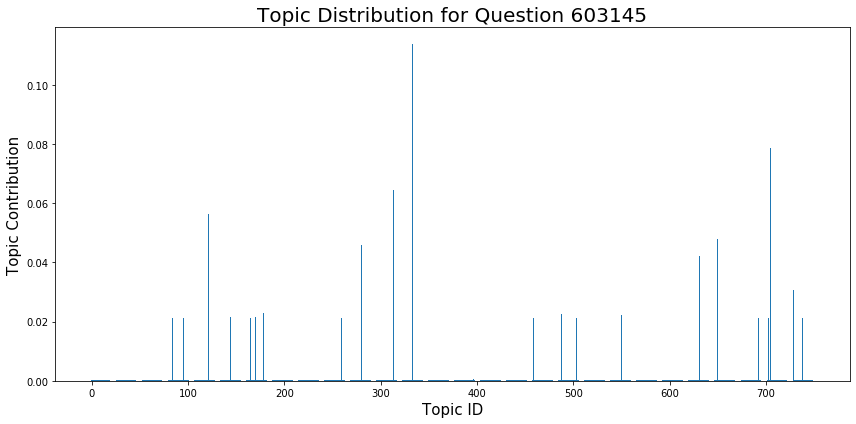

In [0]:
random_article_index = np.random.randint(len(data))
bow = dictionary_lda.doc2bow([w for w in nltk.word_tokenize(data.iloc[random_article_index,1]) if w in model_w2v.wv.vocab])

doc_distribution = np.array([tup[1] for tup in model_lda.get_document_topics(bow=bow)])

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Question " + str(random_article_index), fontsize=20)
fig.tight_layout()
plt.show()

In [0]:
start_time = time.time()

from tqdm import tqdm

def LDA_topics(corpus,model):
    output = np.zeros(shape=(len(corpus), 750), dtype = np.float32)
    for i,s in enumerate(tqdm(corpus)):
      v =  np.array([[tup[1] for tup in lst] for lst in model[[s]]])
      output[i] = v
    return output

doc_topic_dist = LDA_topics(corpus_lda,model_lda)
print("time taken to conevrt to topics {0} minutes".format((time.time() - start_time)/60))
print("shape:",doc_topic_dist.shape)

100%|██████████| 929480/929480 [1:23:08<00:00, 186.34it/s]

time taken to conevrt to topics 83.15902031262716 minutes
shape: (929480, 750)


In [0]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix[None,:].T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))[0]

def get_most_similar_documents(query,matrix,k=5):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = np.array([jensen_shannon(query,p) for p in matrix]) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [0]:
query = "dataframe filter rows pandas"
query_bow = dictionary_lda.doc2bow([w for w in nltk.word_tokenize(query) if w in model_w2v.wv.vocab])

query_doc_distribution = np.array([tup[1] for tup in model_lda.get_document_topics(bow=query_bow)])

query_sim_ids = get_most_similar_documents(query_doc_distribution,doc_topic_dist)

In [0]:
most_similar_df = data[data.index.isin(query_sim_ids)]
most_similar_df['title']

10512                 How to do a column sum in Tensorflow?
144695                      Join pandas series of multIndex
626721                      SQLAlchemy Relationship Filter?
636914               What is as_index in groupby in pandas?
716673    How to get the column name when iterating thro...
Name: title, dtype: object

In [0]:
np.save(modelsDirectory+'doc_topic_dist', doc_topic_dist)

In [0]:
drive.flush_and_unmount()

#<h1>Search Engine</h1>

In [0]:
from PythonModules import DataPreProcess,StackOverFlowTagModel

with open(modelsDirectory+'tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
  
with open(modelsDirectory+'multiLabel.pickle', 'rb') as handle:
    encoder = pickle.load(handle)

tagModel = StackOverFlowTagModel.buildModel()
tagModel.load_weights(modelsDirectory  + "tagClassifier/best1.hdf5")

all_tags = sparse.csr_matrix(encoder.transform(data['tags']))

def predict_tags(model,query,encoder,printTags=False):
    query_process = DataPreProcess.TextPreprocessor().transform(query)
    query_token = tokenizer.texts_to_sequences([query_process])
    query_pad = pad_sequences(query_token, maxlen=150, padding='pre')

    prediction = model.predict(query_pad)[0]
    prediction = np.array(prediction >= 0.5,dtype=np.int32)
    
    tags = encoder.inverse_transform(np.array([prediction]))
    if(printTags):
        print("Predicted Tags: for '{0}' is {1}".format(query,tags))
    return query_process,prediction,tags

In [0]:
def stackOverflow_searchEngine(query, data,tagModel, all_tags,all_sentence_emb,vectorizerFunc, model,model2=None, k = 5):
    start_time = time.time()
    query,query_tag_prediction,tags = predict_tags(tagModel,query,encoder)
    query_tag_prediction = query_tag_prediction.reshape(1,-1)
    
    if model2 is None:
        query_vect = vectorizerFunc([query], model)   # Vectorize the user query
    else:
        query_vect = vectorizerFunc([query], model,model2)   # Vectorize the user query
    
    # Calculate Cosine similarites for the query and all titles
    cosine_similarities = pd.Series(cosine_similarity(query_vect, all_sentence_emb)[0])

    tagWeight = pd.Series(cosine_similarity(query_tag_prediction, all_tags)[0])
    
    # Custom Similarity Measure
    cosine_similarities = cosine_similarities*(1 + 0.5*tagWeight)
    cosine_similarities = cosine_similarities*(1 + 0.1*data.score)

    return list(cosine_similarities.nlargest(int(k)).index),time.time() - start_time



def compareResults(query,data):
    indexDict = {}

    query_process,query_tag_prediction,tags = predict_tags(tagModel,query,encoder)

    indexDict['Avg W2V'] = stackOverflow_searchEngine(query_process, data, tagModel, all_tags, avg_W2V_emb, AvgWord2VecEmbeddings, model_w2v)

    indexDict['TF-IDF'] = stackOverflow_searchEngine(query_process, data, tagModel, all_tags, TF_IDF_W2V_emb,TF_IDF_Word2VecEmbeddings,model_w2v,model_tfidf)

    indexDict['SIF'] = stackOverflow_searchEngine(query_process, data, tagModel, all_tags, SIF_W2V_emb, SIFWord2VecEmbeddings, model_w2v)

    indexDict['USE'] = stackOverflow_searchEngine(query, data, tagModel, all_tags, USE_emb,USE_Embeddings,model_USE)

    indexDict['BERT'] = stackOverflow_searchEngine(query, data, tagModel, all_tags, BERT_emb,BERT_Embeddings, model_bert)

    output = ""
    output += "<h1 style='text-align:center'> Top results for '" + query + "'</h1>"
    output += "<h2 style='text-align:center'> Tags: " + str(tags) + " </h2>"
    output += "</br><table> <tr>"
    for i in indexDict.keys():
        output += "<th style='padding:0px;margin:0px;border:1px solid black;width:300px;text-align:center;font-size:25px;\
        font-weight:bold'><div>" + i + "</div></th>"
    output += "</tr>"

    output += "<tr>"
    for modelName in indexDict.keys():
        output += "<td style='width:300px;height:400px;border:1px solid black;font-size:20px;'>"
        output += "<ol>"
        for idx,index in enumerate(indexDict[modelName][0]):
            output += "<li style='margin-bottom: 1em'>" + data.title[index] + "(" + \
                      "<a href = 'https://stackoverflow.com/questions/"+str(data.id[index])+"'>link</a>" +  ")</li>"
        output += "</ol>"
        output += "<div style='text-align:center;font-size:18px'> Time taken to retrive results: " + "{0:.2f}".format(indexDict[modelName][1]) + \
                  " seconds </div></td>"
    output += "</tr>"

    output += "</table>"
    display(HTML(output))
    return

In [0]:
query = "How to Perform a groupby with sum in a dataframe?"
compareResults(query,data)

Avg W2V,TF-IDF,SIF,USE,BERT
Pandas - Get value as frequency in groupby(link)Combining groupby and apply in multiIndex DataFrames(link)Code Optimization for groupby(link)pandas groupby without turning grouped by column into index(link)After Grouping ..Sum of a column values based on the groups in pandas dataframe(link) Time taken to retrive results: 2.03 seconds,groupby 1 column and sum of other columns as new dataframe pandas(link)Code Optimization for groupby(link)Combining groupby and apply in multiIndex DataFrames(link)Pandas - Get value as frequency in groupby(link)pandas dataframe sum with groupby(link) Time taken to retrive results: 2.34 seconds,groupby 1 column and sum of other columns as new dataframe pandas(link)Code Optimization for groupby(link)How to access python groupby objects values(link)Pandas - Get value as frequency in groupby(link)Combining groupby and apply in multiIndex DataFrames(link) Time taken to retrive results: 2.15 seconds,"How to unpivot a pandas dataframe based on some grouped column?(link)Dask Dataframe groupby has no len()(link)Apply a weighted average function to a dataframe without grouping it, as if it was a single group(link)Filtering Pandas Dataframe Aggregate(link)Pandas python Initializing groupby object with empty groups(link) Time taken to retrive results: 2.89 seconds","Numpy: vectorize sum of lagged differences(link)How to get the aggregate result only on the first occurrence, and 0 to the other, in a computation with groupby and transform?(link)Calculation between groups in a Pandas multiindex dataframe(link)multiple row selection in multi indexed dataframe(link)Map two dataframes and perform sum operation using a dictionary(link) Time taken to retrive results: 4.13 seconds"


In [0]:
query = "How to do web scraping?"
compareResults(query,data)

Avg W2V,TF-IDF,SIF,USE,BERT
Is Heritrix3.2.0 able to crawl ajax-based web sites?(link)Web scraping with Java(link)Web scraping with Python(link)Use Django Framework with Website and Stand-alone App(link)Python web scraping - Where to begin(link) Time taken to retrive results: 2.25 seconds,Web scraping with Java(link)Web mining or scraping or crawling? What tool/library should I use?(link)Is Heritrix3.2.0 able to crawl ajax-based web sites?(link)Python web scraping - Where to begin(link)Scraping a website with python 3 that requires login(link) Time taken to retrive results: 2.37 seconds,Web scraping with Java(link)Python web scraping - Where to begin(link)Web mining or scraping or crawling? What tool/library should I use?(link)Return data from URL with Python(link)Screen Scraping in Python(link) Time taken to retrive results: 2.25 seconds,Web scraping with Java(link)Web Scrape in Python(link)Web Scraping specific page with Python(link)Python: scraping results of webpage of which results are generated server-side(link)web scraping java beginner(link) Time taken to retrive results: 3.06 seconds,Python web scraping with beautifulsoup - can't extract Principal Investigator from Clinicaltrials.gov(link)Web Scraping with Selenium Python [Twitter + Instagram](link)web scraping using beautifulsoup: separating values(link)Web Scraping Extract Javascript Table Selenium+Python(link)What Python-only HTTP/1.1 web servers are available?(link) Time taken to retrive results: 4.54 seconds


In [0]:
query = "How to check duplicate entries or values in a dataframe?"
compareResults(query,data)

Avg W2V,TF-IDF,SIF,USE,BERT
Find index of all rows with null values in a particular column in pandas dataframe(link)Check for duplicate values in dataframe column(link)how to set values to rows of boolean filtered dataframe column(link)create Pandas Dataframe with unique index(link)How to replace all non-NaN entries of a dataframe with 1 and all NaN with 0(link) Time taken to retrive results: 2.15 seconds,How to drop duplicates in Pandas DataFrame by checking for a condition?(link)Pandas search for duplicate rows in one column which have different values in another column(link)Find index of all rows with null values in a particular column in pandas dataframe(link)How to replace all non-NaN entries of a dataframe with 1 and all NaN with 0(link)Remove non-duplicated entries(link) Time taken to retrive results: 2.49 seconds,"How to drop duplicates in Pandas DataFrame by checking for a condition?(link)Pandas search for duplicate rows in one column which have different values in another column(link)Python Pandas find all rows where all values are NaN(link)Pandas: unique dataframe(link)Find duplicated rows, multiply a certain column by number of duplicates, drop duplicated rows(link) Time taken to retrive results: 2.28 seconds",Pandas: unique dataframe(link)Checking the duplicate values of multiple columns in a row in a dataframe.(link)check for duplicates in Pyspark Dataframe(link)Fill empty values in a dataframe based on columns in another dataframe(link)Find extra values after comparing two columns of dataframe python(link) Time taken to retrive results: 3.11 seconds,Checking the duplicate values of multiple columns in a row in a dataframe.(link)checking range of number and writing a value in a new column in pandas dataframe(link)Python pandas replace value in column(link)Storing dictionaries inside a dataframe that have duplicate entries in a unique value column(link)Replace other columns of duplicate rows with first unique value and create lookup(link) Time taken to retrive results: 4.34 seconds


In [0]:
query = "How to fill missing values?"
compareResults(query,data)

Avg W2V,TF-IDF,SIF,USE,BERT
Filling the missing index and filling its value with 0(link)Fill in missing row values in pandas dataframe(link)Pandas fillna: Output still has NaN values(link)Opposite of dropna() in pandas(link)Dealing with missing value in a column using pandas(link) Time taken to retrive results: 2.16 seconds,Filling the missing index and filling its value with 0(link)Pandas - filling NaNs in Categorical data(link)Pandas fillna: Output still has NaN values(link)Filling missing values with mode of column relative to another column in Python(link)loop drop columns over number of missing values(link) Time taken to retrive results: 2.45 seconds,"Filling the missing index and filling its value with 0(link)Filling missing lines with ""nan"" with pandas reindex(link)Pandas - filling NaNs in Categorical data(link)How to fill up this python list?(link)Fill with Nan when Length of values does not match length of index(link) Time taken to retrive results: 2.18 seconds",Opposite of dropna() in pandas(link)fill multiple missing values with series based on index values(link)Binning with zero values in pandas(link)conditionally filling the missing values based on the other variables available(link)Adding missing time in pandas dataframe(link) Time taken to retrive results: 3.11 seconds,"How to fill missing values with similar rows median(link)How to fill nan values with rolling mean in pandas(link)Fill in missing row values in pandas dataframe(link)Using xlrd, how to replace missing/NaN cells(link)transform on multiple columns to interpolate/copy missing values(link) Time taken to retrive results: 4.81 seconds"
